<a href="https://colab.research.google.com/github/Tsadoq/iCarl/blob/master/incremental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

**CHECK FOR DECENT GPU** (not K80)

In [0]:
!nvidia-smi

Mon Jun  8 22:31:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Install python packages**

In [0]:
# !pip3 install 'torch==1.4.0'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Imports**

In [0]:
import os
import logging
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms


from PIL import Image
from tqdm import tqdm

import copy
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedShuffleSplit
import dill

**Download dataset**

In [0]:
# if not os.path.isdir('./cifar-100-python'):
#   !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
#   !tar xfz cifar-100-python.tar.gz

**MACROS**

In [0]:
DEVICE = 'cuda'

NUM_EPOCHS = 70
BATCH_SIZE = 128
LR = 2.0
GAMMA = 0.2
K = 2000
FIRST_STEP = 49
SECOND_STEP = 63

**Load datasets**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))                                    
])

In [0]:
train_dataset = torchvision.datasets.CIFAR100('./', train=True, transform=train_transform, target_transform=None, download=True)
test_dataset = torchvision.datasets.CIFAR100('./', train=False, transform=eval_transform, target_transform=None, download=False)

Files already downloaded and verified


# **Split Dataset into batches of 10 classes**

In [0]:
labels = train_dataset.classes.copy()
random.seed(666)
random.shuffle(labels)
incremental_mapping = {v: k for k, v in enumerate(labels)}
partitions = []
for i in range(10):
  partitions.append(labels[i*10:(i+1)*10])

In [0]:
class BatchDataset:
  def __init__(self, dataset, labels, split='train', transform=None, target_transform=None, mapping = incremental_mapping):
    self.data_per_label=[]
    self.split = split
    self.transform = transform
    self.target_transform = target_transform
    self.data = []
    self.labels = labels
    self.labels_to_int = [incremental_mapping[label] for label in labels]
    
    for label in labels: 
      data_per_label=[(dataset.data[x], int(self.labels_to_int[labels.index(label)])) for x in [index for index, element in enumerate(dataset.targets) if element == dataset.class_to_idx[label]]]
      self.data+=data_per_label
      self.data_per_label.append(data_per_label)
  def __getitem__(self, index):
    image, label = self.data[index]
    if self.transform is not None:
      image = self.transform(image)
    return index, image, label

  def __len__(self):
    return len(self.data)

**Create splits**

In [0]:
train_datasets = []
# val_datasets = []
test_datasets = []
for i, partition in enumerate(partitions):
  batch_test=BatchDataset(test_dataset,partition,transform=eval_transform, mapping = incremental_mapping)
  test_datasets.append(batch_test)
  batch = BatchDataset(train_dataset, partition,transform=train_transform, mapping = incremental_mapping)
  train_datasets.append(batch)
  # sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
  # for train_indexes, val_indexes in sss.split(range(len(batch)), [x[1] for x in batch.data]):
    # batch_val_dataset = Subset(batch, val_indexes)
    # batch_train_dataset = Subset(batch, train_indexes)
    # train_datasets.append(batch_train_dataset)
    # val_datasets.append(batch_val_dataset)


# **ResNet32**

**ResNets for CIFAR100**

In [0]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.out_dim = 64 * block.expansion

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model


# **iCaRL model**

ICARL NET 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

class iCarlNet(nn.Module):

  def __init__(self, n_classes):
    self.total_num_classes = n_classes
    self.known_classes = 0
    self.list_known_classes=[]
    self.exemplar_sets = []
    self.flag_mean = True
    self.exemplar_means = []
    self.exemplars_list_knn=[]
    self.labels_knn=[]
    # We take a standard ResNet and Extend it
    super(iCarlNet, self).__init__()
    self.extractor = resnet32()
    self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
    torch.nn.init.xavier_uniform_(self.fully_connected.weight)

    self.fully_connected.bias.data.fill_(0.01)
    self.loss=nn.BCEWithLogitsLoss()
        
  def forward(self, x):
      # X: input data

      self.extractor.to(DEVICE)
      self.fully_connected.to(DEVICE)

      x = self.extractor(x)
      x = self.fully_connected(x)

      return x

  # def classify(self, input_image_batch, transform):
  #   # input_image_batch: batch of up to 10 shuffled classes that we use for training and validation
  #   # transform: transformation to be applied to raw exemplar images
  #   batch_size = input_image_batch.size(0)
  #   self.eval()

  #   # compute exemplar means when calling right after update_representation
  #   with torch.no_grad():
  #     if self.flag_mean:
  #       print(f"num exemplar sets: {len(self.exemplar_sets)}")
  #       exemplar_means = []
  #       for exemplars in self.exemplar_sets:
  #         features = []
  #         for exemplar in exemplars:
  #           feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
  #           feature.data = feature.data / feature.data.norm()
  #           features.append(feature)
  #         features = torch.stack(features)
  #         exemplar_mean = torch.mean(features, 0)
  #         exemplar_means.append(exemplar_mean)
  #       print(f"Exemplar means len: {len(exemplar_means)}")
  #       self.exemplar_means = exemplar_means
  #       self.flag_mean = False

  #     # mean: tensor of dimensions known_classes x features (64)
  #     mean = torch.stack(self.exemplar_means).squeeze(1)    
  #     # extract the features of the whole batch
  #     features = self.extractor(input_image_batch)          
  #     predictions = []
  #     # normalize and predict by nearest exemplar mean
  #     for n, feature in enumerate(features):
  #       feature.data = feature.data / feature.data.norm() 
  #       distances = torch.sum((feature - mean)**2, 1)
  #       predictions.append(torch.argmin(distances, 0))
  #     return predictions

  # def classify_without_mean(self,input_image_batch):
  #   # input image batch: batch of 128 images to compute predictions on

  #   self.eval()
  #   with torch.no_grad():
  #     # mean: tensor of dimension: known_classes x features (64)
  #     mean = torch.stack(self.exemplar_means).squeeze(1).cuda()
  #     # extract the features of the whole batch 
  #     self.extractor.to(DEVICE)   
  #     features = self.extractor(input_image_batch)        
  #     predictions = []

  #     # normalize and predict by nearest exemplar mean
  #     for n, feature in enumerate(features):
  #       feature.data = feature.data / feature.data.norm()   
  #       distances = torch.sum((feature - mean)**2, 1)
  #       predictions.append(torch.argmin(distances, 0))
  #     return predictions
  
  def classify_without_mean_cosine_similarity(self,input_image_batch):
    # input image batch: batch of 128 images to compute predictions on

    self.eval()
    with torch.no_grad():
      # mean: tensor of dimension: known_classes x features (64)
      mean = torch.stack(self.exemplar_means).squeeze(1).cuda()
      # extract the features of the whole batch 
      self.extractor.to(DEVICE)   
      features = self.extractor(input_image_batch)        
      predictions = []

      # normalize and predict by nearest exemplar mean
      for n, feature in enumerate(features):
        feature.data = feature.data / feature.data.norm() 
        feature=feature.expand_as(mean)
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-08)
        distances=cosine_similarity(feature,mean)
        predictions.append(torch.argmax(distances, 0))
      return predictions

  def compute_exemplar_list_knn(self,transform):
    self.eval()
    with torch.no_grad():
      exemplar_features = []
      labels=[]
      for i,exemplars in enumerate(self.exemplar_sets):
        for exemplar in exemplars:
          feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
          feature.data = feature.data / feature.data.norm()
          exemplar_features.append(feature)
          labels.append(i)
      
      self.exemplars_list_knn=exemplar_features
      self.labels_knn=labels

  def KNN_classify(self,input_image_batch,k):
    exemplar_features=torch.stack(self.exemplars_list_knn).squeeze(1)
    self.eval()
    with torch.no_grad():
      # mean: tensor of dimension: known_classes x features (64)
      # mean = torch.stack(self.exemplar_means).squeeze(1).cuda()
      # extract the features of the whole batch 
      self.extractor.to(DEVICE)   
      features = self.extractor(input_image_batch)        
      predictions = []

      # normalize and predict by nearest exemplar mean
      for n, feature in enumerate(features):
        labels_knn=[]
        feature.data = feature.data / feature.data.norm() 
        feature=feature.expand_as(exemplar_features)
        l2_distances=torch.sum((feature - exemplar_features)**2, 1)
        knn=l2_distances.topk(k, largest=False)
        for index in knn.indices.tolist():
          labels_knn.append(self.labels_knn[index])
        predictions.append(torch.tensor(max(set(labels_knn),key=labels_knn.count)))
      return predictions

  # def compute_means(self,transform):
  #   # transform: transformation to be applied to raw exemplar images
  #   self.eval()
  #   with torch.no_grad():
  #     print(f"num exemplar sets: {len(self.exemplar_sets)}")
  #     exemplar_means = []
  #     for exemplars in self.exemplar_sets:
  #       features = []
  #       for exemplar in exemplars:
  #         feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
  #         feature.data = feature.data / feature.data.norm()
  #         features.append(feature)
  #       features = torch.stack(features)
  #       exemplar_mean = torch.mean(features, 0)
  #       exemplar_means.append(exemplar_mean)
  #     print(f"Exemplar means len: {len(exemplar_means)}")
  #     self.exemplar_means = exemplar_means
  #     self.flag_mean = False

  # def construct_exemplar_set_with_class_mean(self, images, exemplars_per_class, transform):
  #   # images: batch of a single class, used to construct exemplar sets
  #   # exemplars per class: m = K/known_classes
  #   # transform: transformation to be applied to raw exemplar images

  #   self.eval()
  #   with torch.no_grad():
  #     # to be computed only one time, after the update representation
  #     if self.flag_mean:
  #       print(f"num exemplar sets: {len(self.exemplar_sets)}")
  #       exemplar_means = []
  #       for exemplars in self.exemplar_sets:
  #         features = []
  #         for exemplar in exemplars:
  #           # extract features and normalize
  #           feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
  #           feature.data = feature.data / feature.data.norm()
  #           features.append(feature)
  #         # features is a tensor m x 64, where m is the number of exemplars in a set
  #         features = torch.stack(features)
  #         exemplar_mean = torch.mean(features, 0)
  #         exemplar_means.append(exemplar_mean)
  #       print(f"Exemplar means len: {len(exemplar_means)}")
  #       self.exemplar_means = exemplar_means
  #       self.flag_mean = False
  
  #     images_features = []
  #     exemplar_set = []
  #     exemplar_features = []

  #     # compute the features of all images
  #     for image in images:
  #       image = transform(image[0]).to(DEVICE).unsqueeze(0)
  #       feature = self.extractor(image)
  #       feature.data = feature.data / feature.data.norm()
  #       images_features.append(feature)
  #     # images_features is a tensor n x 64, where n is the number of images of a class
  #     images_features = torch.stack(images_features, dim=0)
  #     class_mean = torch.mean(images_features, 0)
  #     class_mean = class_mean / class_mean.norm()
  #     # for the "new classes" use the mean computed on all data of the class instead
  #     # of using a limited number of exemplars
  #     self.exemplar_means.append(class_mean)

  #     # choose exemplars based on distance from class mean
  #     for i in range(exemplars_per_class):
  #       mask = [True]*len(images)
  #       total = np.sum(exemplar_features, axis=0)
  #       extracted_features = images_features
  #       mean = class_mean
  #       average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
  #       average_feature_vector = average_feature_vector / average_feature_vector.norm()
  #       j = torch.argmin(torch.sqrt(
  #           torch.sum(mean-average_feature_vector, 1)**2))
  #       exemplar_set.append(images[j][0])
  #       exemplar_features.append(extracted_features[j].squeeze(0))
  #       mask[j] = False
  #       images_features = images_features[mask]
  #       images = np.array(images)[mask].tolist()

  #     self.exemplar_sets.append(exemplar_set)
  #     print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  # def construct_examplar_set_random(self, images, exemplars_per_class, transform):
  #   # images: batch of a single class, used to construct exemplar sets
  #   # exemplars per class: m = K/known_classes
  #   # transform: transformation to be applied to raw exemplar images

  #   self.eval()
  #   with torch.no_grad():
  #     images_features = []
  #     exemplar_set = []
  #     exemplar_features = []

  #     for image in images:
  #       image = transform(image[0]).to(DEVICE).unsqueeze(0)
  #       feature = self.extractor(image)
  #       feature.data = feature.data / feature.data.norm()
  #       images_features.append(feature)

  #     # images_features is a tensor n x 64, where n is the number of images of a class
  #     images_features = torch.stack(images_features, dim=0)
  #     class_mean = torch.mean(images_features, 0)
  #     class_mean = class_mean / class_mean.norm()
  #     # for the "new classes" use the mean computed on all data of the class instead
  #     # of using a limited number of exemplars
  #     self.exemplar_means.append(class_mean)

  #     # choose exemplars at random (avoids overfitting when considering few exemplars)
  #     for i in range(exemplars_per_class):                
  #       mask = [True]*len(images)
  #       j = random.choice(range(len(images)))
  #       exemplar_set.append(images[j][0])
  #       mask[j] = False
  #       images_features = images_features[mask]
  #       images = np.array(images)[mask].tolist()

  #     self.exemplar_sets.append(exemplar_set)
  #     print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  # def construct_exemplar_set(self, images, exemplars_per_class, transform):
  #   # images: batch of a single class, used to construct exemplar sets
  #   # exemplars per class: m = K/known_classes
  #   # transform: transformation to be applied to raw exemplar images

  #   self.eval()
  #   with torch.no_grad():
  #     images_features = []
  #     exemplar_set = []
  #     exemplar_features = []

  #     # compute the features of all images
  #     for image in images:
  #       image = transform(image[0]).to(DEVICE).unsqueeze(0)
  #       feature = self.extractor(image)
  #       feature.data = feature.data / feature.data.norm()
  #       images_features.append(feature)
  #     # images_features is a tensor n x 64, where n is the number of images of a class
  #     images_features = torch.stack(images_features, dim=0)
  #     class_mean = torch.mean(images_features, 0)
  #     class_mean = class_mean / class_mean.norm()
  #     # for the "new classes" use the mean computed on all data of the class instead
  #     # of using a limited number of exemplars
  #     self.exemplar_means.append(class_mean)

  #     # choose exemplars based on distance from class mean
  #     for i in range(exemplars_per_class):
  #       mask = [True]*len(images)
  #       total = np.sum(exemplar_features, axis=0)
  #       extracted_features = images_features
  #       mean = class_mean
  #       average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
  #       average_feature_vector = average_feature_vector / average_feature_vector.norm()
  #       j = torch.argmin(torch.sqrt(
  #           torch.sum(mean-average_feature_vector, 1)**2))
  #       exemplar_set.append(images[j][0])
  #       exemplar_features.append(extracted_features[j].squeeze(0))
  #       mask[j] = False
  #       images_features = images_features[mask]
  #       images = np.array(images)[mask].tolist()

  #     self.exemplar_sets.append(exemplar_set)
  #     print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  # def increment_classes(self, classes_to_add):
  #   # increments the number of classes we are using
  #   # classes_to_add: list of new classes          
  #   n_classes_to_add = len(classes_to_add)
  #   self.list_known_classes+=classes_to_add
  #   print(f"Known classes {self.list_known_classes}")
  #   weight = self.fully_connected.weight.data
  #   feature_size = self.fully_connected.in_features
  #   old_num_classes = self.fully_connected.out_features
  #   # edit last classification layer to accomodate new classes, keep previuos weights for old classes
  #   self.fully_connected = nn.Linear(
  #       feature_size, old_num_classes+n_classes_to_add, bias = True)
  #   self.fully_connected.weight.data[:old_num_classes] = weight

  # def reduce_exemplar_sets(self, m):
  #   # m: new size for exemplar sets                    
  #   for i in range(len(self.exemplar_sets)):
  #     self.exemplar_sets[i] = self.exemplar_sets[i][:m]
  #     print(f"Reducing exemplars of class {i} to {len(self.exemplar_sets[i])}")

  # def combine_dataset_with_exemplars(self, dataset):
  #   # dataset: training data to be used in update_representation, 
  #   #          append exemplars
  #   list_exemplars = []
  #   for label, exemplars in enumerate(self.exemplar_sets):
  #     list_exemplars += [(image, label) for image in exemplars]
  #     dataset.labels_to_int.append(label)
  #   dataset.data = list_exemplars + dataset.data

  # def update_representation(self, dataset):
  #   # dataset: training data belonging to 10 new classes

  #   ########################################
  #   optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
  #   scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
  #   ########################################

  #   self.combine_dataset_with_exemplars(dataset)
  #   self.flag_mean = True
  #   classes_to_idx = dataset.labels_to_int
  #   new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes]

  #   train_data_loader = DataLoader(
  #       dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
  #   # if some classes have been previously observed, compute the
  #   # outputs of the new data on the old weights
  #   if self.known_classes > 0:
  #     logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
  #     self.eval()
  #     with torch.no_grad():
  #       for indices, images, labels in train_data_loader:
  #         images = images.to(DEVICE)
  #         g = self.forward(images)
  #         sigmoid = torch.nn.Sigmoid()
  #         logits_old_net[indices] = sigmoid(g)
  #     torch.cuda.empty_cache()

  #   self.increment_classes(new_classes)
    
  #   # start training on the new batch of 10 classes + exemplars
  #   self.train()
  #   eye = torch.eye(self.known_classes+len(new_classes))

  #   for epoch in range(NUM_EPOCHS):
  #     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
  #     for indices, images, labels in train_data_loader:
  #       images = images.to(DEVICE)
  #       labels = labels.to(DEVICE)
  #       indices = indices.to(DEVICE)

  #       optimizer.zero_grad()
        
  #       output = self.forward(images)

  #       # for the first batch: calculate loss using as target the one hot encoded labels
  #       # no knowledge of previous classes, classification loss only
  #       if self.known_classes==0:
  #         # one hot encode new classes

  #         labels_one_hot_new_classes = []
  #         for label in labels:
  #           labels_one_hot_new_classes.append(eye[label])
  #         labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()

  #         loss=self.loss(output,labels_one_hot_new_classes)
  #         loss.backward()

  #       # calculate loss taking into account knowledge of previous classes and performance on
  #       # the previous net's weights, clf + dst
  #       if self.known_classes > 0:
  #         labels_one_hot_new_classes = eye[:, self.known_classes:]
  #         labels_one_hot = []
  #         for label in labels:
  #           labels_one_hot.append(labels_one_hot_new_classes[label])
  #         labels_one_hot = torch.stack(labels_one_hot).cuda()
  #         logits = logits_old_net[indices].cuda()

  #         # concatenate old network's logits and new labels one hot encoded (0 for old classes)
  #         labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
  #         loss=self.loss(output,labels_concatenate)
  #         loss.backward()

  #       optimizer.step()
  #     torch.cuda.empty_cache()
  #     print(f"Loss: {loss.item()}")
  #     scheduler.step() 
  #   # increment number of known classes to accomodate newly learned 10 classes
  #   self.known_classes += len(new_classes)

  def update_representation_using_cross_entropy_and_kl(self, dataset):
    # dataset: training data belonging to 10 new classes

    ########################################
    loss1=nn.CrossEntropyLoss(ignore_index=-1)
    loss2=nn.KLDivLoss()
    sigmoid = nn.Sigmoid()
    log_sigmoid = nn.LogSigmoid()
    softmax = nn.Softmax()
    log_softmax = nn.LogSoftmax()
    optimizer = optim.SGD(self.parameters(), lr=2,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
    ########################################

    self.combine_dataset_with_exemplars(dataset)
    self.flag_mean = True
    classes_to_idx = dataset.labels_to_int
    new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes]

    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    # if some classes have been previously observed, compute the
    # outputs of the new data on the old weights

    if self.known_classes > 0:
      self.eval()
      logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()

      with torch.no_grad():
        for indices, images, labels in train_data_loader:
          images = images.to(DEVICE)
          g = self.forward(images)
          logits_old_net[indices] = sigmoid(g)

      torch.cuda.empty_cache()

    self.increment_classes(new_classes)
    
    # start training on the new batch of 10 classes + exemplars
    self.train()
    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        output = self.forward(images)

        # classification loss only for the first batch of 10 classes
        if self.known_classes==0:
          #labels_one_hot_new_classes = []
          #for label in labels:
          #  labels_one_hot_new_classes.append(eye[label])
          #labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
          #loss=self.loss(output,labels_one_hot_new_classes)
          loss=loss1(output,labels)
          loss.backward()
        # clf + dst loss
        if self.known_classes > 0:
          #labels_one_hot_new_classes = eye[:, self.known_classes:]
          # print(labels_one_hot_new_classes.size())
          #labels_one_hot = []
          #for label in labels:
          #  labels_one_hot.append(labels_one_hot_new_classes[label])
          #labels_one_hot = torch.stack(labels_one_hot).cuda()
          logits = logits_old_net[indices].cuda()
          # print(f"logits old net: {logits.size()}")
          # print(f"new classes onehot encoded: {labels_one_hot.size()}")
          #labels_concatenate = torch.zeros(logits_old_net.size()
          # print(f"{logits.size()}-{labels_one_hot.size()}")
          #labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
          loss_classification=loss1(output,labels)
          loss_distillation=loss2(log_sigmoid(output[:,:self.known_classes]),logits)
          loss=loss_classification+loss_distillation
          loss.backward()
        optimizer.step()
        i+=1
      torch.cuda.empty_cache()
      print(f"Loss: {loss.item()}")
      scheduler.step() 
    self.known_classes += len(new_classes)



# ## OLD METHODS


  def update_representation(self, dataset):             
    self.combine_dataset_with_exemplars(dataset)
    self.flag_mean = True
    classes_to_idx = dataset.labels_to_int
    new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

    train_data_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    preds_old_net = []
    #preds_old_net = torch.zeros(len(dataset), self.num_classes).cuda()
    
    if self.known_classes > 0:

      self.eval()
      logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
      with torch.no_grad():
        for indices, images, labels in train_data_loader:
          images = images.to(DEVICE)
          g = self.forward(images)
          sigmoid = torch.nn.Sigmoid()
          logits_old_net[indices] = sigmoid(g)
        # preds_old_net.append(g.data)
        # preds_old_net[indices] = g.data
      
      # print(f"Labels old net size: {preds_old_net.size()}")
      # print(f"Labels old net: {preds_old_net}")
      # preds_old_net = preds_old_net.to(DEVICE)
      # logits_old_net = torch.cat(logits_old_net)         
      # print(logits_old_net.size())
      torch.cuda.empty_cache()

    self.increment_classes(new_classes)
    
    optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
    scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
    self.train()

    eye = torch.eye(self.known_classes+len(new_classes))

    for epoch in range(NUM_EPOCHS):
      print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
      i=0
      for indices, images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        indices = indices.to(DEVICE)
        optimizer.zero_grad()
        output = self.forward(images)
        # print(f"Output size: {output.size()}")
        # print(f"Labels size: {labels.size()}")

        if self.known_classes==0:
          labels_one_hot_new_classes = []
          for label in labels:
            labels_one_hot_new_classes.append(eye[label])
          labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
          loss=self.loss(output,labels_one_hot_new_classes)
          loss.backward()
        if self.known_classes > 0:
          labels_one_hot_new_classes = eye[:, self.known_classes:]
          # print(labels_one_hot_new_classes.size())
          labels_one_hot = []
          for label in labels:
            labels_one_hot.append(labels_one_hot_new_classes[label])
          labels_one_hot = torch.stack(labels_one_hot).cuda()
          logits = logits_old_net[indices].cuda()
          # print(f"logits old net: {logits.size()}")
          # print(f"new classes onehot encoded: {labels_one_hot.size()}")
          #labels_concatenate = torch.zeros(logits_old_net.size()
          # print(f"{logits.size()}-{labels_one_hot.size()}")
          labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
          loss=self.loss(output,labels_concatenate)
          loss.backward()
        optimizer.step()
        i+=1
      torch.cuda.empty_cache()
      print(f"Loss: {loss.item()}")
      scheduler.step() 
    self.known_classes += len(new_classes)

  def classify(self, input_image_batch, transform):
      # input_image_batch: batch of up to 10 shuffled classes that we use for training and validation
      # transform: transformation to be applied to raw exemplar images
      batch_size = input_image_batch.size(0)
      self.eval()
      with torch.no_grad():
        if self.flag_mean:
          print(f"num exemplar sets: {len(self.exemplar_sets)}")
          exemplar_means = []
          for exemplars in self.exemplar_sets:
            features = []
            for exemplar in exemplars:
              feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
              feature.data = feature.data / feature.data.norm()
              features.append(feature)
            features = torch.stack(features)
            exemplar_mean = torch.mean(features, 0)
            exemplar_means.append(exemplar_mean)
          print(f"Exemplar means len: {len(exemplar_means)}")
          self.exemplar_means = exemplar_means
          self.flag_mean = False


        mean = torch.stack(self.exemplar_means).squeeze(1)    # tensor of dimension: known_classes x features (64)
        # print(mean.size())
        features = self.extractor(input_image_batch)          # extracts the features of the batch
        predictions = []
        for n, feature in enumerate(features):
          feature.data = feature.data / feature.data.norm()   # normalize and returns the distance of the nearest one
        # Predict label by nearest exemplar mean
          distances = torch.sum((feature - mean)**2, 1)
          predictions.append(torch.argmin(distances, 0))
        return predictions

  def classify_without_mean(self,input_image_batch):
    # input_image_batch: batch of up to 10 shuffled classes that we use for training and validation

    self.eval()
    with torch.no_grad():
      # mean: tensor of dimensions known_classes x features (64)
      mean = torch.stack(self.exemplar_means).squeeze(1)    

      features = self.extractor(input_image_batch)          # extracts the features of the batch
      predictions = []
      for n, feature in enumerate(features):
        feature.data = feature.data / feature.data.norm()   # normalize and returns the distance of the nearest one
        # Predict label by nearest exemplar mean
        distances = torch.sum((feature - mean)**2, 1)
        predictions.append(torch.argmin(distances, 0))
      return predictions

  def construct_with_class_mean(self, images, exemplars_per_class, transform):
    self.eval()
    with torch.no_grad():
      if self.flag_mean:
        print(f"num exemplar sets: {len(self.exemplar_sets)}")
        exemplar_means = []
        for exemplars in self.exemplar_sets:
          features = []
          for exemplar in exemplars:
            feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
            feature.data = feature.data / feature.data.norm()
            features.append(feature)
          features = torch.stack(features)
          exemplar_mean = torch.mean(features, 0)
          exemplar_means.append(exemplar_mean)
        print(f"Exemplar means len: {len(exemplar_means)}")
        self.exemplar_means = exemplar_means
        self.flag_mean = False
  
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)
      for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
        mask = [True]*len(images)
        total = np.sum(exemplar_features, axis=0)
        extracted_features = images_features
        mean = class_mean
        average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
        average_feature_vector = average_feature_vector / average_feature_vector.norm()
        j = torch.argmin(torch.sqrt(
            torch.sum(mean-average_feature_vector, 1)**2))
        exemplar_set.append(images[j][0])
        exemplar_features.append(extracted_features[j].squeeze(0))
        mask[j] = False
        images_features = images_features[mask]
        images = np.array(images)[mask].tolist()
      self.exemplar_sets.append(exemplar_set)
      print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def construct_exemplar_set(self, images, exemplars_per_class, transform):     # images: images of one class of the training set, exemplars_per_class is m, transform is the transformation
      self.eval()
      with torch.no_grad():
        images_features = []
        exemplar_set = []
        exemplar_features = []
        for image in images:
          image = transform(image[0]).to(DEVICE).unsqueeze(0)
          feature = self.extractor(image)
          feature.data = feature.data / feature.data.norm()
          images_features.append(feature)
        images_features = torch.stack(images_features, dim=0)
        # should do the mean on the dimension of the append
        class_mean = torch.mean(images_features, 0)
        class_mean = class_mean / class_mean.norm()         #computes the mean of the class and normalizes it, it creates the features of the average image

        for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
          mask = [True]*len(images)
          total = np.sum(exemplar_features, axis=0)
          extracted_features = images_features
          mean = class_mean
          average_feature_vector = (float(1)/(i+1))*(extracted_features + total).squeeze(1)
          average_feature_vector = average_feature_vector / average_feature_vector.norm()
          j = torch.argmin(torch.sqrt(
              torch.sum(mean-average_feature_vector, 1)**2))
          exemplar_set.append(images[j][0])
          exemplar_features.append(extracted_features[j].squeeze(0))
          mask[j] = False
          images_features = images_features[mask]
          images = np.array(images)[mask].tolist()
        self.exemplar_sets.append(exemplar_set)
        print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def construct_examplar_set_random(self, images, exemplars_per_class, transform):
    self.eval()
    with torch.no_grad():
  
      images_features = []
      exemplar_set = []
      exemplar_features = []
      for image in images:
        image = transform(image[0]).to(DEVICE).unsqueeze(0)
        feature = self.extractor(image)
        feature.data = feature.data / feature.data.norm()
        images_features.append(feature)
      images_features = torch.stack(images_features, dim=0)
      # should do the mean on the dimension of the append
      class_mean = torch.mean(images_features, 0)
      class_mean = class_mean / class_mean.norm()
      self.exemplar_means.append(class_mean)
      for i in range(exemplars_per_class):                #gets the nearest image to the mean and returns it
        mask = [True]*len(images)
        j = random.choice(range(len(images)))
        exemplar_set.append(images[j][0])
        mask[j] = False
        images_features = images_features[mask]
        images = np.array(images)[mask].tolist()
      self.exemplar_sets.append(exemplar_set)
      print(f"Created exemplar set for class {images[0][1]} of len {len(self.exemplar_sets[0])}")

  def compute_means(self,transform):
    self.eval()
    with torch.no_grad():
      print(f"num exemplar sets: {len(self.exemplar_sets)}")
      exemplar_means = []
      for exemplars in self.exemplar_sets:
        features = []
        for exemplar in exemplars:
          feature = self.extractor(transform(exemplar).unsqueeze(0).cuda())
          feature.data = feature.data / feature.data.norm()
          features.append(feature)
        features = torch.stack(features)
        exemplar_mean = torch.mean(features, 0)
        exemplar_means.append(exemplar_mean)
      print(f"Exemplar means len: {len(exemplar_means)}")
      self.exemplar_means = exemplar_means
      self.flag_mean = False

  def combine_dataset_with_exemplars(self, dataset):    #combines them
    list_exemplars = []
    for label, exemplars in enumerate(self.exemplar_sets):
      list_exemplars += [(image, label) for image in exemplars]
      dataset.labels_to_int.append(label)
    dataset.data = list_exemplars + dataset.data

  def increment_classes(self, classes_to_add):          # increments the number of classes we are using
    n_classes_to_add = len(classes_to_add)
    self.list_known_classes+=classes_to_add             #add the new classes
    print(f"Known classes {self.list_known_classes}")
    weight = self.fully_connected.weight.data
    feature_size = self.fully_connected.in_features
    old_num_classes = self.fully_connected.out_features
    self.fully_connected = nn.Linear(
        feature_size, old_num_classes+n_classes_to_add, bias = True)
    self.fully_connected.weight.data[:old_num_classes] = weight

  def reduce_exemplar_sets(self, m):                    # reduces exemplar set
      for i in range(len(self.exemplar_sets)):
        self.exemplar_sets[i] = self.exemplar_sets[i][:m]
        print(f"Reducing exemplars of class {i} to {len(self.exemplar_sets[i])}")


TRAINING AND VALIDATE ICARL 


In [0]:
net=iCarlNet(n_classes=100)
net.to(DEVICE)
accuracies = []
for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))
  #net.update_representation_using_cross_entropy_and_kl(copy.deepcopy(train_dataset))

  m = int(K/((i+1)*10))
  net.compute_means(train_dataset.transform)
  net.reduce_exemplar_sets(m)
  for data_per_label in train_dataset.data_per_label:
    print(f"Constructing exemplar for class [{data_per_label[0][1]}]")
    #net.construct_exemplar_set(data_per_label,m,train_dataset.transform)
    #net.construct_exemplar_set_with_class_mean(data_per_label,m,train_dataset.transform)
    net.construct_examplar_set_random(data_per_label,m,train_dataset.transform)
  # net.compute_exemplar_list_knn(train_dataset.transform)
  net.eval()
  corrects = 0
  total = 0
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # classify using NME
        # preds = torch.stack(net.KNN_classify(images,100)).cuda()
        preds = torch.stack(net.classify_without_mean(images)).cuda()
        # Update Corrects
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)
    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch [1/70], LR: [2.0]
Loss: 0.3305477797985077
Epoch [2/70], LR: [2.0]
Loss: 0.3301875591278076
Epoch [3/70], LR: [2.0]
Loss: 0.3216121196746826
Epoch [4/70], LR: [2.0]
Loss: 0.313019722700119
Epoch [5/70], LR: [2.0]
Loss: 0.3104317784309387
Epoch [6/70], LR: [2.0]
Loss: 0.3262775242328644
Epoch [7/70], LR: [2.0]
Loss: 0.33550313115119934
Epoch [8/70], LR: [2.0]
Loss: 0.29964563250541687
Epoch [9/70], LR: [2.0]
Loss: 0.2753533720970154
Epoch [10/70], LR: [2.0]
Loss: 0.22768452763557434
Epoch [11/70], LR: [2.0]
Loss: 0.27266407012939453
Epoch [12/70], LR: [2.0]
Loss: 0.3421652317047119
Epoch [13/70], LR: [2.0]
Loss: 0.3417690396308899
Epoch [14/70], LR: [2.0]
Loss: 0.3070462644100189
Epoch [15/70], LR: [2.0]
Loss: 0.2794950604438782
Epoch [16/70], LR: [2.0]
Loss: 0.3483972251415252

**Plot of accuracy over learned classes**

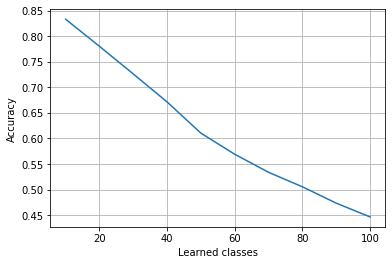

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Learned classes')
plt.plot(np.arange(10, 110, 10), accuracies)
plt.grid(True)
plt.show()

# **Learning without Fortgetting (LwF) model**

**LwF**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

class LwF(nn.Module):
    def __init__(self, n_classes):
        self.total_num_classes = n_classes
        self.known_classes = 0
        self.list_known_classes=[]
        self.exemplar_sets = []
        self.flag_mean = True
        self.exemplar_means = []

        # We take a standard ResNet and Extend it
        super(LwF, self).__init__()
        self.extractor = resnet32()
        self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
        torch.nn.init.xavier_uniform_(self.fully_connected.weight)

        self.fully_connected.bias.data.fill_(0.01)
        self.loss=nn.BCEWithLogitsLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001)
        self.scheduler=MultiStepLR(self.optimizer,[47,63],gamma=GAMMA)
        
    def forward(self, x):
        # X: input data
        self.extractor.to(DEVICE)
        self.fully_connected.to(DEVICE)
        x = self.extractor(x)
        x = self.fully_connected(x)
        return x

    def increment_classes(self, classes_to_add):          # increments the number of classes we are using
      n_classes_to_add = len(classes_to_add)
      self.list_known_classes+=classes_to_add             #add the new classes
      print(f"Known classes {self.list_known_classes}")
      weight = self.fully_connected.weight.data
      feature_size = self.fully_connected.in_features
      old_num_classes = self.fully_connected.out_features
      self.fully_connected = nn.Linear(
          feature_size, old_num_classes+n_classes_to_add, bias = True)
      self.fully_connected.weight.data[:old_num_classes] = weight

    def update_representation(self, dataset):             
        # self.combine_dataset_with_exemplars(dataset)
        # self.flag_mean = True
        classes_to_idx = dataset.labels_to_int
        new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

        train_data_loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        
        preds_old_net = []
        #preds_old_net = torch.zeros(len(dataset), self.num_classes).cuda()
        
        if self.known_classes > 0:

          self.eval()
          logits_old_net = torch.zeros(len(dataset.data), self.known_classes).cuda()
          with torch.no_grad():
            for indices, images, labels in train_data_loader:
              images = images.to(DEVICE)
              g = self.forward(images)
              sigmoid = torch.nn.Sigmoid()
              logits_old_net[indices] = sigmoid(g)

          torch.cuda.empty_cache()

        self.increment_classes(new_classes)
        
        optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
        scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
        self.train()

        eye = torch.eye(self.known_classes+len(new_classes))

        for epoch in range(NUM_EPOCHS):
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
          i=0
          for indices, images, labels in train_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            indices = indices.to(DEVICE)
            optimizer.zero_grad()
            output = self.forward(images)

            if self.known_classes==0:
              labels_one_hot_new_classes = []
              for label in labels:
                labels_one_hot_new_classes.append(eye[label])
              labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
              loss=self.loss(output,labels_one_hot_new_classes)
              loss.backward()
            if self.known_classes > 0:
              labels_one_hot_new_classes = eye[:, self.known_classes:]
 
              labels_one_hot = []
              for label in labels:
                labels_one_hot.append(labels_one_hot_new_classes[label])
              labels_one_hot = torch.stack(labels_one_hot).cuda()
              logits = logits_old_net[indices].cuda()
              labels_concatenate=torch.cat((logits,labels_one_hot),dim=1)
              loss=self.loss(output,labels_concatenate)
              loss.backward()
            optimizer.step()
            i+=1
          torch.cuda.empty_cache()
          print(f"Loss: {loss.item()}")
          scheduler.step() 
        self.known_classes += len(new_classes)
    

**Training LwF**

In [0]:
net = LwF(n_classes=100)
net.to(DEVICE)

for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))

  net.eval()
  corrects = 0
  total = 0
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)

    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch [1/70], LR: [2.0]
Loss: 0.32896044850349426
Epoch [2/70], LR: [2.0]
Loss: 0.344553679227829
Epoch [3/70], LR: [2.0]
Loss: 0.31547585129737854
Epoch [4/70], LR: [2.0]
Loss: 0.28766587376594543
Epoch [5/70], LR: [2.0]
Loss: 0.297115296125412
Epoch [6/70], LR: [2.0]
Loss: 0.33089154958724976
Epoch [7/70], LR: [2.0]
Loss: 0.2954370677471161
Epoch [8/70], LR: [2.0]
Loss: 0.2477138489484787
Epoch [9/70], LR: [2.0]
Loss: 0.29497846961021423
Epoch [10/70], LR: [2.0]
Loss: 0.25300318002700806
Epoch [11/70], LR: [2.0]
Loss: 0.32428231835365295
Epoch [12/70], LR: [2.0]
Loss: 0.29303112626075745
Epoch [13/70], LR: [2.0]
Loss: 0.3104630708694458
Epoch [14/70], LR: [2.0]
Loss: 0.29044392704963684
Epoch [15/70], LR: [2.0]
Loss: 0.31014809012413025
Epoch [16/70], LR: [2.0]
Loss: 0.26986250281

# **Catastrophic forgetting model (finetuning on iCaRL paper)**

CATASTROPHIC FORGETTING NET



In [0]:
class CatastrophicForgetting(nn.Module):
    def __init__(self, n_classes):
        self.total_num_classes = n_classes
        self.known_classes = 0
        self.list_known_classes=[]
        self.exemplar_sets = []
        self.flag_mean = True
        self.exemplar_means = []

        # We take a standard ResNet and Extend it
        super(CatastrophicForgetting, self).__init__()
        self.extractor = resnet32()
        self.fully_connected = nn.Linear(self.extractor.out_dim, 0, bias=True)
        torch.nn.init.xavier_uniform_(self.fully_connected.weight)

        self.fully_connected.bias.data.fill_(0.01)
        self.loss=nn.BCEWithLogitsLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001)
        self.scheduler=MultiStepLR(self.optimizer,[47,63],gamma=GAMMA)
        
    def forward(self, x):
        # X: input data
        self.extractor.to(DEVICE)
        self.fully_connected.to(DEVICE)
        x = self.extractor(x)
        x = self.fully_connected(x)
        return x


    def increment_classes(self, classes_to_add):          # increments the number of classes we are using
      n_classes_to_add = len(classes_to_add)
      self.list_known_classes+=classes_to_add             #add the new classes
      print(f"Known classes {self.list_known_classes}")
      weight = self.fully_connected.weight.data
      feature_size = self.fully_connected.in_features
      old_num_classes = self.fully_connected.out_features
      self.fully_connected = nn.Linear(
          feature_size, old_num_classes+n_classes_to_add, bias = True)
      self.fully_connected.weight.data[:old_num_classes] = weight


    def update_representation(self, dataset):             
        classes_to_idx = dataset.labels_to_int
        new_classes = [cls for cls in classes_to_idx if cls not in self.list_known_classes] #gets indexes of new classes only

        train_data_loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        self.increment_classes(new_classes)
        
        optimizer = optim.SGD(self.parameters(), lr=2.0,weight_decay=0.00001, momentum = 0.9)
        scheduler = MultiStepLR(optimizer,[47,63],gamma=GAMMA)
        self.train()

        eye = torch.eye(self.known_classes+len(new_classes))

        for epoch in range(NUM_EPOCHS):
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR: {scheduler.get_last_lr()}")
          i=0
          for indices, images, labels in train_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            indices = indices.to(DEVICE)
            optimizer.zero_grad()
            output = self.forward(images)
            
            labels_one_hot_new_classes = []
            for label in labels:
              labels_one_hot_new_classes.append(eye[label])
            labels_one_hot_new_classes = torch.stack(labels_one_hot_new_classes).cuda()
            loss=self.loss(output,labels_one_hot_new_classes)
            loss.backward()
            optimizer.step()
          torch.cuda.empty_cache()
          print(f"Loss: {loss.item()}")
          scheduler.step() 
        self.known_classes += len(new_classes)


TRAINING CATASTROPHIC FORGETTING

In [0]:
net = CatastrophicForgetting(n_classes=100)
net.to(DEVICE)

for i, train_dataset in enumerate(train_datasets):
  torch.cuda.empty_cache()
  print(f"BATCH [{i}]")
  print(f"Training on {train_dataset.labels} -> {train_dataset.labels_to_int}")
  net.train()
  net.update_representation(copy.deepcopy(train_dataset))


  net.eval()
  corrects = 0
  total = 0
  with torch.no_grad():
    for num in range(i+1):
      print(f"Validating classes {test_datasets[num].labels} -> {test_datasets[num].labels_to_int}")
      test_dataloader = DataLoader(test_datasets[num], batch_size=BATCH_SIZE, num_workers=4, shuffle = True)
      for _, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        corrects += torch.sum(preds == labels.data).data.item()
        total += len(images)
    torch.cuda.empty_cache()
    # Calculate Accuracy
    accuracy = corrects / float(total)
    print(f"Accuracy: {accuracy}")

BATCH [0]
Training on ['palm_tree', 'bottle', 'man', 'mushroom', 'snail', 'tiger', 'beaver', 'skyscraper', 'wardrobe', 'train'] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch [1/70], LR: [2.0]
Loss: 0.3104826807975769
Epoch [2/70], LR: [2.0]
Loss: 0.3267080783843994
Epoch [3/70], LR: [2.0]
Loss: 0.33472558856010437
Epoch [4/70], LR: [2.0]
Loss: 0.3417496681213379
Epoch [5/70], LR: [2.0]
Loss: 0.33384209871292114
Epoch [6/70], LR: [2.0]
Loss: 0.3297256827354431
Epoch [7/70], LR: [2.0]
Loss: 0.3167625367641449
Epoch [8/70], LR: [2.0]
Loss: 0.3126598298549652
Epoch [9/70], LR: [2.0]
Loss: 0.3189757764339447
Epoch [10/70], LR: [2.0]
Loss: 0.3290937542915344
Epoch [11/70], LR: [2.0]
Loss: 0.348395437002182
Epoch [12/70], LR: [2.0]
Loss: 0.2938593327999115
Epoch [13/70], LR: [2.0]
Loss: 0.2551422715187073
Epoch [14/70], LR: [2.0]
Loss: 0.26085516810417175
Epoch [15/70], LR: [2.0]
Loss: 0.2518620491027832
Epoch [16/70], LR: [2.0]
Loss: 0.24940279126167297